<a href="https://colab.research.google.com/github/OJB-Quantum/Notebooks-for-Ideas/blob/main/Wigner_Function_for_Cat_State.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Authored by Onri Jay Benally (2025)

Open Access (CC-BY-4.0)

I *cannot* run this code for you, as it requires a specific GPU-enabled environment (Google Colab with a T4 GPU) that isn't part of my toolkit. However, I *can* provide you with the exact, self-contained Python script to paste directly into a Google Colab notebook to achieve your goal.

This code will:

1.  **Install** `qutip` and the `qutip-cupy` library, which allows QuTiP to use CuPy for GPU calculations.
2.  **Set up** the QuTiP environment to use the `cupy` data backend.
3.  **Verify** that it's successfully using the T4 GPU.
4.  **Generate** a static Matplotlib plot of the Wigner function for a **Fock state ($n=1$)**.
5.  **Generate** an animated GIF of the Wigner function for a **Schrödinger Cat state** as it evolves (rotates) in phase space.

### Google Colab Code (CuPy + T4 GPU)

In [3]:
# @title Step 0 — Install QuTiP + CuPy + qutip-cupy (auto-detect CUDA)
# PEP 8/257 compliant. Robust CuPy wheel selection for Colab.
from __future__ import annotations

import re
import subprocess
import sys

def sh(*args: str) -> None:
    """Run a shell command quietly, raising on failure."""
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q"] + list(args))

print("Upgrading pip tooling…")
sh("--upgrade", "pip", "setuptools", "wheel")

# Detect CUDA from nvidia-smi output (typical in Colab GPU runtimes).
cuda_major = 12
try:
    smi = subprocess.check_output(["nvidia-smi"], encoding="utf-8", errors="ignore")
    m = re.search(r"CUDA Version:\s*([0-9]+)\.", smi)
    if m:
        cuda_major = int(m.group(1))
except Exception:
    pass

cupy_pkg = "cupy-cuda12x" if cuda_major >= 12 else "cupy-cuda11x"
print(f"Installing CuPy wheel: {cupy_pkg}")
try:
    sh(cupy_pkg)
except subprocess.CalledProcessError:
    # Fallbacks (rarely needed).
    try:
        sh("cupy")
    except subprocess.CalledProcessError:
        print("Warning: CuPy wheel not found; continuing without GPU.")

print("Installing QuTiP 5+ and matplotlib…")
sh("qutip>=5.1", "matplotlib>=3.8", "pillow>=10")

print("Installing qutip-cupy from GitHub (plugin data layer)…")
# qutip-cupy is distributed from GitHub (README indicates Git install).
# Ref: https://github.com/qutip/qutip-cupy
sh("git+https://github.com/qutip/qutip-cupy.git")

print("Done. Restart not required in Colab.")


Upgrading pip tooling…
Installing CuPy wheel: cupy-cuda12x
Installing QuTiP 5+ and matplotlib…
Installing qutip-cupy from GitHub (plugin data layer)…
Done. Restart not required in Colab.


In [4]:
# @title Step 1 — Imports, GPU setup, helpers, and control knobs
from __future__ import annotations

from dataclasses import dataclass
from typing import Tuple

import numpy as np
import matplotlib.pyplot as plt

# CuPy & QuTiP
import cupy as cp
import qutip as qt  # QuTiP 5+
import qutip_cupy  # registers the CuPy data layer plugin

# Optional: set the default dtype to plugin type if available.
# Plugin README uses "cupyd" for CuPyDense. If unavailable, we still use .to("cupyd") ad hoc.
try:
    qt.settings.core["default_dtype"] = "cupyd"
except Exception:
    pass

def is_gpu_qobj(obj: qt.Qobj) -> bool:
    """Return True if Qobj holds CuPy-backed data (qutip_cupy)."""
    return "qutip_cupy" in obj.data.__class__.__module__

def to_gpu(obj: qt.Qobj) -> qt.Qobj:
    """Convert Qobj to GPU-backed dtype if plugin is present."""
    try:
        return obj.to("cupyd")
    except Exception:
        return obj  # stay CPU if conversion not available

def asnumpy(arr) -> np.ndarray:
    """Return a NumPy array, copying from CuPy if needed."""
    try:
        import cupy as _cp  # late import in case CuPy missing
        if isinstance(arr, _cp.ndarray):
            return _cp.asnumpy(arr)
    except Exception:
        pass
    return np.asarray(arr)

def device_banner() -> str:
    """Human-readable GPU/CPU banner."""
    try:
        dev = cp.cuda.Device()
        name = cp.cuda.runtime.getDeviceProperties(dev.id)["name"].decode() \
               if isinstance(cp.cuda.runtime.getDeviceProperties(dev.id)["name"], bytes) \
               else cp.cuda.runtime.getDeviceProperties(dev.id)["name"]
        return f"CuPy device: {name}"
    except Exception as exc:
        return f"CuPy device: unavailable ({exc})"

print("--- Runtime info ---")
print(device_banner())
print("QuTiP version:", qt.__version__)
print("qutip-cupy loaded:", "qutip_cupy" in globals())

# Matplotlib defaults
plt.rcParams.update({
    "figure.dpi": 110,
    "savefig.dpi": 110,
    "axes.grid": False,
    "image.interpolation": "nearest",
})

@dataclass
class GridKnobs:
    """Phase-space grid control knobs."""
    half_range: float = 5.0
    points: int = 200

    def mesh(self) -> Tuple[np.ndarray, np.ndarray]:
        x = np.linspace(-self.half_range, self.half_range, self.points)
        y = np.linspace(-self.half_range, self.half_range, self.points)
        return x, y

@dataclass
class PlotKnobs:
    """Visualization control knobs."""
    figsize: Tuple[float, float] = (8.0, 7.0)
    title_size: int = 16
    label_size: int = 14

@dataclass
class EvolKnobs:
    """Evolution/animation control knobs."""
    N: int = 30                 # Hilbert dimension
    frames: int = 100
    period: float = 2 * np.pi   # rotation period for H = a† a
    fps: int = 20
    out_gif: str = "cat_state_evolution.gif"


--- Runtime info ---
CuPy device: Tesla T4
QuTiP version: 5.2.2
qutip-cupy loaded: True


Fock state lives on GPU: True


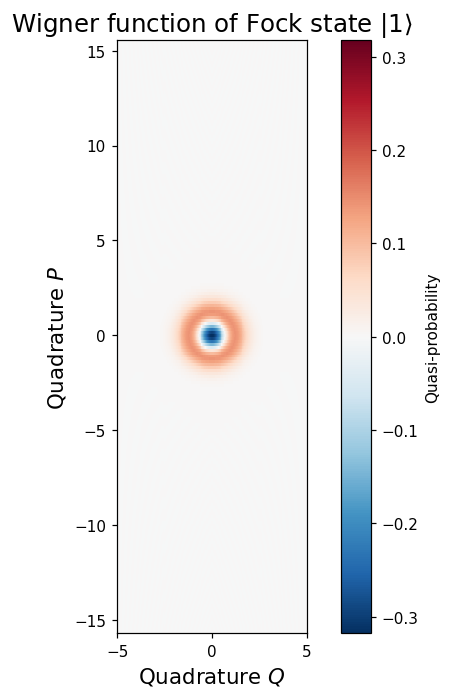

In [6]:
# @title Step 2 — Static Wigner: Fock state |1⟩ (FFT-aware)
from __future__ import annotations

def wigner_grid(psi: qt.Qobj,
                x: np.ndarray,
                y: np.ndarray | None = None,
                use_fft: bool = True) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
    """Return (x_plot, y_plot, W) with consistent shapes.
    If use_fft is True, pass only x to QuTiP; it returns (W, y_fft).
    """
    if use_fft:
        # QuTiP FFT mode: supply x only; get (W, y_fft) back.
        W_fft, y_fft = qt.wigner(psi, x, method="fft")
        return asnumpy(x), asnumpy(y_fft), asnumpy(W_fft)
    else:
        # Non-FFT path: user supplies both axes; W is returned directly.
        if y is None:
            raise ValueError("y must be provided when use_fft=False")
        W = qt.wigner(psi, x, y)
        return asnumpy(x), asnumpy(y), asnumpy(W)

# Controls
grid = GridKnobs(half_range=5.0, points=200)
viz = PlotKnobs()

# State: Fock |1⟩, GPU-backed
N = 30
psi_fock = to_gpu(qt.fock(N, 1))
print(f"Fock state lives on GPU: {is_gpu_qobj(psi_fock)}")

# Build grid and compute Wigner with FFT mode
xvec, _ = grid.mesh()                 # ignore the y produced here; FFT will supply its own
xplot, yplot, W = wigner_grid(psi_fock, xvec, use_fft=True)

# Plot
fig, ax = plt.subplots(figsize=viz.figsize)
vmax = float(np.max(np.abs(W)))
im = ax.pcolormesh(xplot, yplot, W, shading="auto",
                   cmap="RdBu_r", vmin=-vmax, vmax=vmax)
ax.set_aspect("equal")
ax.set_title(r"Wigner function of Fock state $|1\rangle$", fontsize=viz.title_size)
ax.set_xlabel(r"Quadrature $Q$", fontsize=viz.label_size)
ax.set_ylabel(r"Quadrature $P$", fontsize=viz.label_size)
fig.colorbar(im, ax=ax, label="Quasi-probability")
plt.show()

In [8]:
# @title Step 3 — Animated Wigner: cat state via GPU unitary stepping (FFT-aware)
from __future__ import annotations

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
from IPython.display import HTML, display

import qutip as qt

# ---------- Helpers (safe fallbacks if Step 2 wasn't run) ----------
try:
    wigner_grid  # noqa: F821
except NameError:
    def _asnumpy(arr):
        try:
            import cupy as _cp  # type: ignore
            if isinstance(arr, _cp.ndarray):
                return _cp.asnumpy(arr)
        except Exception:
            pass
        import numpy as _np
        return _np.asarray(arr)

    def wigner_grid(psi: qt.Qobj,
                    x: np.ndarray,
                    y: np.ndarray | None = None,
                    use_fft: bool = True) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
        """Return (x_plot, y_plot, W). In FFT mode, pass only x; QuTiP returns (W, y_fft)."""
        if use_fft:
            W_fft, y_fft = qt.wigner(psi, x, method="fft")
            return _asnumpy(x), _asnumpy(y_fft), _asnumpy(W_fft)
        if y is None:
            raise ValueError("y must be provided when use_fft=False")
        W = qt.wigner(psi, x, y)
        return _asnumpy(x), _asnumpy(y), _asnumpy(W)

try:
    to_gpu  # noqa: F821
except NameError:
    def to_gpu(obj: qt.Qobj) -> qt.Qobj:
        """No-op fallback if Step 1 not run."""
        try:
            return obj.to("cupyd")
        except Exception:
            return obj

# ---------- Controls (reuse your dataclasses if Step 1 ran) ----------
try:
    EvolKnobs, GridKnobs, PlotKnobs  # noqa: F821
except NameError:
    from dataclasses import dataclass
    from typing import Tuple
    @dataclass
    class EvolKnobs:
        N: int = 30
        frames: int = 100
        period: float = 2 * np.pi
        fps: int = 20
        out_gif: str = "cat_state_evolution.gif"
    @dataclass
    class GridKnobs:
        half_range: float = 5.0
        points: int = 200
        def mesh(self) -> tuple[np.ndarray, np.ndarray]:
            x = np.linspace(-self.half_range, self.half_range, self.points)
            y = np.linspace(-self.half_range, self.half_range, self.points)
            return x, y
    @dataclass
    class PlotKnobs:
        figsize: Tuple[float, float] = (8.0, 7.0)
        title_size: int = 16
        label_size: int = 14

# ---------- Time evolution on GPU by reusing a single unitary step ----------
def evolve_by_unitary_on_gpu(H: qt.Qobj, psi0: qt.Qobj, tlist: np.ndarray) -> list[qt.Qobj]:
    """Compute ψ(t_k) with ψ←U(Δt)ψ, where U(Δt)=exp(-iHΔt). Keeps data on GPU when available."""
    assert tlist.ndim == 1 and len(tlist) >= 1
    if len(tlist) == 1:
        return [psi0]
    dt = float(tlist[1] - tlist[0])
    U_dt = (-1j * H * dt).expm()   # GPU-resident when H is cupyd
    states = [psi0]
    psi = psi0
    for _ in range(1, len(tlist)):
        psi = U_dt @ psi
        states.append(psi)
    return states

# ---------- Build cat state and evolve ----------
evol = EvolKnobs(N=30, frames=100, period=2*np.pi, fps=20, out_gif="cat_state_evolution.gif")
grid = GridKnobs(half_range=5.0, points=200)
viz = PlotKnobs()

alpha = 2.0
coh_p = to_gpu(qt.coherent(evol.N, alpha))
coh_m = to_gpu(qt.coherent(evol.N, -alpha))
psi0 = (coh_p + coh_m).unit()
H = to_gpu(qt.num(evol.N))

tlist = np.linspace(0.0, evol.period, evol.frames)
states = evolve_by_unitary_on_gpu(H, psi0, tlist)

# ---------- Wigner grid (FFT mode: provide x only; QuTiP returns y) ----------
xvec, _ = grid.mesh()
xplot, yplot, W0 = wigner_grid(states[0], xvec, use_fft=True)

# Stable color scale across frames
vmax = float(np.max(np.abs(W0)))
vmin = -vmax

# ---------- Figure & animation ----------
fig, ax = plt.subplots(figsize=viz.figsize)
pcm = ax.pcolormesh(xplot, yplot, W0, shading="auto", cmap="RdBu_r",
                    vmin=vmin, vmax=vmax)
ax.set_aspect("equal")
ax.set_xlabel(r"Quadrature $Q$", fontsize=viz.label_size)
ax.set_ylabel(r"Quadrature $P$", fontsize=viz.label_size)
ttl = ax.set_title("Wigner function of a cat state (t = 0.00)", fontsize=viz.title_size)
fig.colorbar(pcm, ax=ax, label="Quasi-probability")

def _frame(k: int):
    _, _, Wk = wigner_grid(states[k], xvec, use_fft=True)  # reuse same x; y comes from FFT
    pcm.set_array(Wk.ravel())
    ttl.set_text(f"Wigner function of a cat state (t = {tlist[k]:.2f})")
    return (pcm, ttl)

anim = FuncAnimation(fig, _frame, frames=len(tlist), blit=False, interval=50)
writer = PillowWriter(fps=evol.fps)
anim.save(evol.out_gif, writer=writer)
plt.close(fig)

print(f"Saved GIF → {evol.out_gif}")
display(HTML(anim.to_jshtml()))

Saved GIF → cat_state_evolution.gif
